<a href="https://colab.research.google.com/github/KGuzikowski/Deepfake/blob/pipeline/pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preparation

In [1]:
! git clone https://github.com/Media-Smart/vedadet
! git clone https://github.com/cleardusk/3DDFA_V2.git
% cd vedadet/
! vedadet_root=${PWD}
! pip install -r requirements/build.txt
! pip install -v -e .
print("-------------------- doing face allignment----------")
% cd /content/3DDFA_V2
! sh ./build.sh

Cloning into 'vedadet'...
remote: Enumerating objects: 1026, done.
remote: Counting objects: 100% (128/128), done.
remote: Compressing objects: 100% (100/100), done.
remote: Total 1026 (delta 60), reused 52 (delta 27), pack-reused 898
Receiving objects: 100% (1026/1026), 1.21 MiB | 5.28 MiB/s, done.
Resolving deltas: 100% (444/444), done.
Cloning into '3DDFA_V2'...
remote: Enumerating objects: 682, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 682 (delta 11), reused 18 (delta 6), pack-reused 652
Receiving objects: 100% (682/682), 74.77 MiB | 11.59 MiB/s, done.
Resolving deltas: 100% (352/352), done.
/content/vedadet
Created temporary directory: /tmp/pip-ephem-wheel-cache-gxxqvpb1
Created temporary directory: /tmp/pip-req-tracker-4uyqo2n6
Created requirements tracker '/tmp/pip-req-tracker-4uyqo2n6'
Created temporary directory: /tmp/pip-install-3qvyayjm
Obtaining file:///content/vedadet
  Added file:///content/vedadet t

In [2]:
import os
from tqdm.autonotebook import tqdm
from google.colab import drive
import numpy as np

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  


In [8]:
drive.mount('/content/drive')
%cd /content/vedadet/
!cp /content/drive/MyDrive/Face_Detection/my_infer.py .
#!cp /content/drive/MyDrive/Face_Detection/my_config.py .

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/vedadet


## Additional stuff for data segmentation

In [4]:
import cv2

In [5]:
  def expand_eyebrows(lmrks, eyebrows_expand_mod=1.0):
    if len(lmrks) != 68:
        raise Exception('works only with 68 landmarks')
    lmrks = np.array( lmrks.copy(), dtype=np.int )

    # #nose
    ml_pnt = (lmrks[36] + lmrks[0]) // 2
    mr_pnt = (lmrks[16] + lmrks[45]) // 2

    # mid points between the mid points and eye
    ql_pnt = (lmrks[36] + ml_pnt) // 2
    qr_pnt = (lmrks[45] + mr_pnt) // 2

    # Top of the eye arrays
    bot_l = np.array((ql_pnt, lmrks[36], lmrks[37], lmrks[38], lmrks[39]))
    bot_r = np.array((lmrks[42], lmrks[43], lmrks[44], lmrks[45], qr_pnt))

    # Eyebrow arrays
    top_l = lmrks[17:22]
    top_r = lmrks[22:27]

    # Adjust eyebrow arrays
    lmrks[17:22] = top_l + eyebrows_expand_mod * 0.5 * (top_l - bot_l)
    lmrks[22:27] = top_r + eyebrows_expand_mod * 0.5 * (top_r - bot_r)
    return lmrks 

In [6]:
def get_image_hull_mask (image_shape, image_landmarks, eyebrows_expand_mod=1.0 ):
    hull_mask = np.zeros(image_shape[0:2]+(1,),dtype=np.float32)

    lmrks = expand_eyebrows(image_landmarks, eyebrows_expand_mod)

    r_jaw = (lmrks[0:9], lmrks[17:18])
    l_jaw = (lmrks[8:17], lmrks[26:27])
    r_cheek = (lmrks[17:20], lmrks[8:9])
    l_cheek = (lmrks[24:27], lmrks[8:9])
    nose_ridge = (lmrks[19:25], lmrks[8:9],)
    r_eye = (lmrks[17:22], lmrks[27:28], lmrks[31:36], lmrks[8:9])
    l_eye = (lmrks[22:27], lmrks[27:28], lmrks[31:36], lmrks[8:9])
    nose = (lmrks[27:31], lmrks[31:36])
    parts = [r_jaw, l_jaw, r_cheek, l_cheek, nose_ridge, r_eye, l_eye, nose]

    for item in parts:
        merged = np.concatenate(item)
        cv2.fillConvexPoly(hull_mask, cv2.convexHull(merged), (1,) )

    return hull_mask

## Pipeline

In [84]:
%cd /content/vedadet
from my_infer import face_detected

import yaml

%cd /content/3DDFA_V2/
from FaceBoxes import FaceBoxes
from TDDFA import TDDFA
from utils.render import render
from utils.depth import depth
from utils.pncc import pncc
from utils.uv import uv_tex
from utils.pose import viz_pose
from utils.serialization import ser_to_ply, ser_to_obj
from utils.functions import draw_landmarks, get_suffix
from PIL import Image


import numpy as np
import numpy.linalg as npla
import math
import matplotlib.patches as patches
import torch
import torchvision

import matplotlib.pyplot as plt
from skimage import io

/content/vedadet
/content/3DDFA_V2


### Face allignment stuff

In [13]:
# load config
cfg = yaml.load(open('configs/mb1_120x120.yml'), Loader=yaml.SafeLoader)

# Init FaceBoxes and TDDFA, recommend using onnx flag
onnx_flag = True  # or True to use ONNX to speed up
if onnx_flag:
    !pip install onnxruntime
    
    import os
    os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
    os.environ['OMP_NUM_THREADS'] = '4'
    from FaceBoxes.FaceBoxes_ONNX import FaceBoxes_ONNX
    from TDDFA_ONNX import TDDFA_ONNX

    face_boxes = FaceBoxes_ONNX()
    tddfa = TDDFA_ONNX(**cfg)
else:
    face_boxes = FaceBoxes()
    tddfa = TDDFA(gpu_mode=False, **cfg)

     |████████████████████████████████| 4.5MB 13.2MB/s 


/usr/local/lib/python3.7/dist-packages/torch/onnx/utils.py:1193: UserWarning: No names were found for specified dynamic axes of provided input.Automatically generated names will be applied to each dynamic axes of input input
  'Automatically generated names will be applied to each dynamic axes of input {}'.format(key))
/usr/local/lib/python3.7/dist-packages/torch/onnx/utils.py:1193: UserWarning: No names were found for specified dynamic axes of provided input.Automatically generated names will be applied to each dynamic axes of input output
  'Automatically generated names will be applied to each dynamic axes of input {}'.format(key))


Convert /content/3DDFA_V2/FaceBoxes/weights/FaceBoxesProd.pth to /content/3DDFA_V2/FaceBoxes/weights/FaceBoxesProd.onnx done.


/usr/local/lib/python3.7/dist-packages/torch/onnx/utils.py:1193: UserWarning: No names were found for specified dynamic axes of provided input.Automatically generated names will be applied to each dynamic axes of input alpha_shp
  'Automatically generated names will be applied to each dynamic axes of input {}'.format(key))
/usr/local/lib/python3.7/dist-packages/torch/onnx/utils.py:1193: UserWarning: No names were found for specified dynamic axes of provided input.Automatically generated names will be applied to each dynamic axes of input alpha_exp
  'Automatically generated names will be applied to each dynamic axes of input {}'.format(key))


Convert configs/bfm_noneck_v3.pkl to configs/bfm_noneck_v3.onnx done.
weights/mb1_120x120.onnx does not exist, try to convert the `.pth` version to `.onnx` online
Convert weights/mb1_120x120.pth to weights/mb1_120x120.onnx done.


In [14]:
def umeyama(src, dst, estimate_scale):
    """Estimate N-D similarity transformation with or without scaling.
    Parameters
    ----------
    src : (M, N) array
        Source coordinates.
    dst : (M, N) array
        Destination coordinates.
    estimate_scale : bool
        Whether to estimate scaling factor.
    Returns
    -------
    T : (N + 1, N + 1)
        The homogeneous similarity transformation matrix. The matrix contains
        NaN values only if the problem is not well-conditioned.
    References
    ----------
    .. [1] "Least-squares estimation of transformation parameters between two
            point patterns", Shinji Umeyama, PAMI 1991, DOI: 10.1109/34.88573
    """

    num = src.shape[0]
    dim = src.shape[1]

    # Compute mean of src and dst.
    src_mean = src.mean(axis=0)
    dst_mean = dst.mean(axis=0)

    # Subtract mean from src and dst.
    src_demean = src - src_mean
    dst_demean = dst - dst_mean

    # Eq. (38).
    A = np.dot(dst_demean.T, src_demean) / num

    # Eq. (39).
    d = np.ones((dim,), dtype=np.double)
    if np.linalg.det(A) < 0:
        d[dim - 1] = -1

    T = np.eye(dim + 1, dtype=np.double)

    U, S, V = np.linalg.svd(A)

    # Eq. (40) and (43).
    rank = np.linalg.matrix_rank(A)
    if rank == 0:
        return np.nan * T
    elif rank == dim - 1:
        if np.linalg.det(U) * np.linalg.det(V) > 0:
            T[:dim, :dim] = np.dot(U, V)
        else:
            s = d[dim - 1]
            d[dim - 1] = -1
            T[:dim, :dim] = np.dot(U, np.dot(np.diag(d), V))
            d[dim - 1] = s
    else:
        T[:dim, :dim] = np.dot(U, np.dot(np.diag(d), V))

    if estimate_scale:
        # Eq. (41) and (42).
        scale = 1.0 / src_demean.var(axis=0).sum() * np.dot(S, d)
    else:
        scale = 1.0

    T[:dim, dim] = dst_mean - scale * np.dot(T[:dim, :dim], src_mean.T)
    T[:dim, :dim] *= scale

    return T

In [15]:
landmarks_2D_new = np.array([
[ 0.000213256,  0.106454  ], #17
[ 0.0752622,    0.038915  ], #18
[ 0.18113,      0.0187482 ], #19
[ 0.29077,      0.0344891 ], #20
[ 0.393397,     0.0773906 ], #21
[ 0.586856,     0.0773906 ], #22
[ 0.689483,     0.0344891 ], #23
[ 0.799124,     0.0187482 ], #24
[ 0.904991,     0.038915  ], #25
[ 0.98004,      0.106454  ], #26
[ 0.490127,     0.203352  ], #27
[ 0.490127,     0.307009  ], #28
[ 0.490127,     0.409805  ], #29
[ 0.490127,     0.515625  ], #30
[ 0.36688,      0.587326  ], #31
[ 0.426036,     0.609345  ], #32
[ 0.490127,     0.628106  ], #33
[ 0.554217,     0.609345  ], #34
[ 0.613373,     0.587326  ], #35
[ 0.121737,     0.216423  ], #36
[ 0.187122,     0.178758  ], #37
[ 0.265825,     0.179852  ], #38
[ 0.334606,     0.231733  ], #39
[ 0.260918,     0.245099  ], #40
[ 0.182743,     0.244077  ], #41
[ 0.645647,     0.231733  ], #42
[ 0.714428,     0.179852  ], #43
[ 0.793132,     0.178758  ], #44
[ 0.858516,     0.216423  ], #45
[ 0.79751,      0.244077  ], #46
[ 0.719335,     0.245099  ], #47
[ 0.254149,     0.780233  ], #48
[ 0.726104,     0.780233  ], #54
], dtype=np.float32)

def transform_points(points, mat, invert=False):
    if invert:
        mat = cv2.invertAffineTransform (mat)
    points = np.expand_dims(points, axis=1)
    points = cv2.transform(points, mat, points.shape)
    points = np.squeeze(points)
    return points

def estimate_averaged_yaw(landmarks):
    # Works much better than solvePnP if landmarks from "3DFAN"
    if not isinstance(landmarks, np.ndarray):
        landmarks = np.array (landmarks)
    l = ( (landmarks[27][0]-landmarks[0][0]) + (landmarks[28][0]-landmarks[1][0]) + (landmarks[29][0]-landmarks[2][0]) ) / 3.0   
    r = ( (landmarks[16][0]-landmarks[27][0]) + (landmarks[15][0]-landmarks[28][0]) + (landmarks[14][0]-landmarks[29][0]) ) / 3.0
    return float(r-l)

def get_transform_mat (image_landmarks, output_size, scale=1.0):
    if not isinstance(image_landmarks, np.ndarray):
        image_landmarks = np.array (image_landmarks)


    # estimate landmarks transform from global space to local aligned space with bounds [0..1]
    mat = umeyama( np.concatenate ( [ image_landmarks[17:49] , image_landmarks[54:55] ] ) , landmarks_2D_new, True)[0:2]

    # get corner points in global space
    g_p = transform_points (  np.float32([(0,0),(1,0),(1,1),(0,1),(0.5,0.5) ]) , mat, True)
    g_c = g_p[4]

    # calc diagonal vectors between corners in global space
    tb_diag_vec = (g_p[2]-g_p[0]).astype(np.float32)
    tb_diag_vec /= npla.norm(tb_diag_vec)
    bt_diag_vec = (g_p[1]-g_p[3]).astype(np.float32)
    bt_diag_vec /= npla.norm(bt_diag_vec)

    # calc modifier of diagonal vectors for scale and padding value
    padding, remove_align = 0.7, False
    mod = (1.0 / scale)* ( npla.norm(g_p[0]-g_p[2])*(padding*np.sqrt(2.0) + 0.5) )

    # if face_type == FaceType.WHOLE_FACE:
    #     # adjust vertical offset for WHOLE_FACE, 7% below in order to cover more forehead
    #     vec = (g_p[0]-g_p[3]).astype(np.float32)
    #     vec_len = npla.norm(vec)
    #     vec /= vec_len
    #     g_c += vec*vec_len*0.07

    mat = umeyama( np.concatenate ( [ image_landmarks[17:49] , image_landmarks[54:55] ] ) , landmarks_2D_new, True)[0:2]
    
    # assuming image_landmarks are 3D_Landmarks extracted for HEAD,
    # adjust horizontal offset according to estimated yaw        
    yaw = estimate_averaged_yaw(transform_points (image_landmarks, mat, False))
    
    hvec = (g_p[0]-g_p[1]).astype(np.float32)
    hvec_len = npla.norm(hvec)
    hvec /= hvec_len        

    yaw *= np.abs(math.tanh(yaw*2)) # Damp near zero
    
    g_c -= hvec * (yaw * hvec_len / 2.0)                     

    # adjust vertical offset for HEAD, 50% below
    vvec = (g_p[0]-g_p[3]).astype(np.float32)
    vvec_len = npla.norm(vvec)
    vvec /= vvec_len
    g_c += vvec*vvec_len*0.50

    # calc 3 points in global space to estimate 2d affine transform
    if not remove_align:
        l_t = np.array( [ g_c - tb_diag_vec*mod,
                          g_c + bt_diag_vec*mod,
                          g_c + tb_diag_vec*mod ] )
    else:
        # remove_align - face will be centered in the frame but not aligned
        l_t = np.array( [ g_c - tb_diag_vec*mod,
                          g_c + bt_diag_vec*mod,
                          g_c + tb_diag_vec*mod,
                          g_c - bt_diag_vec*mod,
                         ] )

        # get area of face square in global space
        area = mathlib.polygon_area(l_t[:,0], l_t[:,1] )

        # calc side of square
        side = np.float32(math.sqrt(area) / 2)

        # calc 3 points with unrotated square
        l_t = np.array( [ g_c + [-side,-side],
                          g_c + [ side,-side],
                          g_c + [ side, side] ] )

    # calc affine transform from 3 global space points to 3 local space points size of 'output_size'
    pts2 = np.float32(( (0,0),(output_size,0),(output_size,output_size) ))
    mat = cv2.getAffineTransform(l_t,pts2)
    return mat

In [16]:
def face_allignment(image_landmarks, image_size, image):
    image_to_face_mat = get_transform_mat (image_landmarks, image_size)

    face_image = cv2.warpAffine(image, image_to_face_mat, (image_size, image_size), cv2.INTER_LANCZOS4)
    face_image_landmarks = transform_points (image_landmarks, image_to_face_mat)

    landmarks_bbox = transform_points ( [ (0,0), (0,image_size-1), (image_size-1, image_size-1), (image_size-1,0) ], image_to_face_mat, True)

    return face_image, face_image_landmarks, landmarks_bbox, image_to_face_mat

### O tu

In [104]:
class Pipeline():
  def __init__(self, src_pth=None, dst_pth=None, shape=None):
    self.src_pth = src_pth if src_pth else '/content/gdrive/MyDrive/img/'
    self.dst_pth = dst_pth if dst_pth else '/content/gdrive/MyDrive/dst/'
    self.face_detec_infer = '/content/vedadet/my_infer.py'
    self.face_detec_configs = '/content/drive/MyDrive/Face_Detection/my_configs.py'
    self.shape = shape if shape else 512

  def face_detection(self, img_pth):
    self.res, d_img = face_detected(self.face_detec_configs, img_pth)
#    self.img = d_img[0]
#    plt.imshow(np.array(torchvision.transforms.functional.to_pil_image(self.img[0])))
    self.img = np.array(Image.open(img_pth))

  def face_alignment(self):
    #temp_img = np.array(self.img.cpu().permute(0,2,3,1))[:, ::-1, ...].copy()

    self.img = self.img[..., ::-1]

    #self.img = self.img[..., ::-1]
    #plt.imshow(temp_img)
    param_lst, roi_box_lst = tddfa(self.img, self.res[0])
    self.img = self.img[..., ::-1]
    
    ver_lst = tddfa.recon_vers(param_lst, roi_box_lst, dense_flag=False)
    ver_lst = ver_lst[0][:2].T

    self.face_image, self.face_landmarks, self.landmarks_bbox, self.img_to_face_mat = face_allignment(ver_lst, self.shape, self.img)
    self.img_shape = self.face_image.shape
    
  def face_segmentation(self):
    #jebane gówno co se robi tego tą maske z LandmarkProcessor
    #pass
    full_face_mask = get_image_hull_mask(self.img_shape, self.face_landmarks, eyebrows_expand_mod=1.0)
    return np.clip(full_face_mask, 0, 1)

  def training(self, some_result_i_guess):
    pass
  
  def do_pipeline(self):
    print("detection")
    self.face_detection('/content/drive/MyDrive/img/emo.jpg')
    print("allignment")
    self.face_alignment()
    print("segmentation")
    res = self.face_segmentation()
   # print(res.shape)
    #print(res.max())
    plt.imshow(res.reshape((512, 512)))


detection
allignment
segmentation


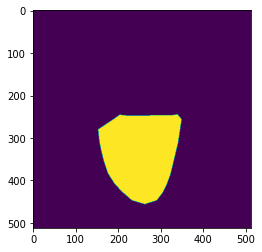

In [105]:
p = Pipeline()
p.do_pipeline()

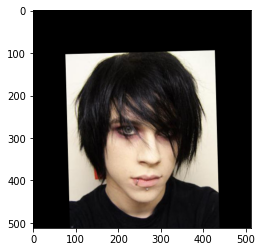

In [106]:
plt.imshow(p.face_image)